# Spark Revision
----------------------------------
## The low level APIs

** RDDs are now the low-level API. **
- In the early spark releases RDDs where the main API for handling data. In the most recent versions of Spark, <font color="red"> it is considered a Low-level API!!</font> 
- Structured APIs, instead, Dataframe, Datasets and SparkSQL are what most users should use regularly to manipulate their data.
- All Spark workloads compile now to the RDD fundamental primitives.
- The authors of Spark recommd that you start with Structured APIs for better productivity.


** When to to use low level APIs? **
- If you need some functionality that you cannot find in the higher level APIs (e.g. custom partitioner). This is naturally the exception.
- You need to maintain some legacy codebase that runs on RDDs.

** Programming Language difference **.
- When you use RDDs, Python or R are slow because conversion is done from Python/R  objects to java objects.
- Therfore Java and scala are faster when using RDDs
- When you use Dataframes or Datasets, no conversion happens, thus all languages have the same performance.


# The Spark Context
- A SparkContext instance is the conncetion a the Spark cluster to create RDDs, accummulators & brodcast variables
- In old versions of Spark there used to be 2 different contexts, SparkContext and SQLContext
- Now we have SparkSeq

<font color='red'>** IMPORTANT:if you the following code twice, you get an error, because the context can not launch multipole times. In case of trouble, from the menu choose kernel->restart** </font>

In [2]:
#These are some printing helper functions we will use to make the output more clear
def title(s):
    print("---- %s -----" %s)    
    
def see(s, v):
    print("---- %s -----" %s)
    print(v)

In [3]:
from pyspark import SparkContext, SparkConf
myconf = SparkConf() \
        .setMaster("local[*]") 
        #.set("spark.driver.cores",4) \
        #.set("spark.executor.memory","2g") 
sc = SparkContext(conf=myconf)

# Resilient Distributed Datasets (RDDs)

- Immutable, partitioned collectioin of elements that can be operated in parallel
- Dataframes and Datasets compile downn to an RDD

------------------
Each RDD is characterized by five main properties:
- A list of partitions
- A function for computing each split
- A list of dependecies on other RDDs
- A partitioner for key-value RDDs (e.g. a hash partitioner)
- Optionally, a list of preferred locations to cpmuter each split on

# Creating RDDS
- from memory
- from files

In [4]:
# from memory
nums = sc.parallelize(range(10000))
animals = sc.parallelize(["cat", "dog", "lion", "bear", "fox"])

print(nums)
print(animals)

PythonRDD[2] at RDD at PythonRDD.scala:48
ParallelCollectionRDD[1] at parallelize at PythonRDD.scala:480


In [5]:
#from file
fileName = "../data/flight-data/csv/2015-summary.csv"
fileRDD =sc.textFile(fileName)
fileRDD

../data/flight-data/csv/2015-summary.csv MapPartitionsRDD[4] at textFile at NativeMethodAccessorImpl.java:0

# RDD operations:
1. actions 
2. transformations
------------------

## RDD operations - Actions (**trigger work**)

In [6]:
animals.collect()

['cat', 'dog', 'lion', 'bear', 'fox']

In [7]:
nums.count()

10000

In [8]:
nums.take(15)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [9]:
fileRDD.take(10)

['DEST_COUNTRY_NAME,ORIGIN_COUNTRY_NAME,count',
 'United States,Romania,15',
 'United States,Croatia,1',
 'United States,Ireland,344',
 'Egypt,United States,15',
 'United States,India,62',
 'United States,Singapore,1',
 'United States,Grenada,62',
 'Costa Rica,United States,588',
 'Senegal,United States,40']

In [10]:
#save to a textfile (a folder with many parts is created)
#CAREFUL, if the output folder already exists, you need to remove it
animals.saveAsTextFile("animals2.txt")

## RDD operations -Transformations(**lazy evaluation**)
**Remeber**: Transformations are not exectued until an action triggers them

In [11]:
#Map
"""Square the numbers"""
squared = nums.map(lambda x: x * x)
squared.take(10)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [12]:
#filter
egyptRDD = fileRDD.filter(lambda x: "Egypt" in x)
egyptRDD.collect()

['Egypt,United States,15', 'United States,Egypt,12']

## RDD operations - Passing Functions to Spark

In [13]:

def containsUS(line): 
    return "United States" in line

usRDD = fileRDD.filter(containsUS)
usRDD.take(5)

['United States,Romania,15',
 'United States,Croatia,1',
 'United States,Ireland,344',
 'Egypt,United States,15',
 'United States,India,62']

# RDD operations - Common Transformations
- flatMap
- dictinct
- sample
- union
- intersect
- subtract
- cartesian
- zip

In [14]:
# flatMap
words = fileRDD.flatMap(lambda line: line.split(",")) 
print(words.count())
words.take(10)

775


['DEST_COUNTRY_NAME',
 'ORIGIN_COUNTRY_NAME',
 'count',
 'United States',
 'Romania',
 '15',
 'United States',
 'Croatia',
 '1',
 'United States']

In [15]:
# distinct
words.distinct().count()

305

In [16]:
# sample
mysample = sc.parallelize(range(100)).sample(withReplacement=False, fraction=0.2, seed=17)
print(mysample.count())
mysample.collect()

22


[7,
 9,
 11,
 19,
 22,
 23,
 30,
 34,
 39,
 41,
 44,
 47,
 50,
 53,
 62,
 66,
 70,
 78,
 79,
 85,
 94,
 98]

In [17]:
#union, intrsection, subtract, catesian
a = sc.parallelize([1,2,3])
b = sc.parallelize([3,4,5])
print (a.collect())
print (b.collect())
print("union: %s" % a.union(b).collect())
print("intersection:%s " % a.intersection(b).collect())
print("subtract: %s" % a.subtract(b).collect())
print("cartesian: %s" % a.cartesian(b).collect())

[1, 2, 3]
[3, 4, 5]
union: [1, 2, 3, 3, 4, 5]
intersection:[3] 
subtract: [1, 2]
cartesian: [(1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 3), (3, 4), (3, 5)]


# RDD operations - Common Actions
- reduce
- fold
- combine
- aggregate

In [18]:
#reduce
nums.reduce(lambda x,y: x+y)

49995000

In [19]:
#top
print(mysample.collect())
mysample.top(3)

[7, 9, 11, 19, 22, 23, 30, 34, 39, 41, 44, 47, 50, 53, 62, 66, 70, 78, 79, 85, 94, 98]


[98, 94, 85]

# Caching

In [20]:
X= sc.parallelize(range(5000000),1)
even = X.filter(lambda x: x % 2 == 0)
squared = even.map(lambda x: x*x)


%time squared.count()
print("----")
%time squared.count()
print("----")
%time squared.count()

CPU times: user 13.7 ms, sys: 2.34 ms, total: 16 ms
Wall time: 1.75 s
----
CPU times: user 6.51 ms, sys: 1.61 ms, total: 8.11 ms
Wall time: 1.58 s
----
CPU times: user 7.98 ms, sys: 1.68 ms, total: 9.66 ms
Wall time: 1.53 s


2500000

In [21]:
squared.persist()
%time squared.count()
print("----")
%time squared.count()
print("----")
%time squared.count()

CPU times: user 4.84 ms, sys: 1.36 ms, total: 6.2 ms
Wall time: 1.88 s
----
CPU times: user 7.69 ms, sys: 2.32 ms, total: 10 ms
Wall time: 314 ms
----
CPU times: user 5.42 ms, sys: 1.37 ms, total: 6.79 ms
Wall time: 339 ms


2500000

# Pair RDDS

## Pair RDDS - creation
- Simple python typles
- all **aggregations** are done on pair RDDs
- first item in the tuple is the key
- second item is the value
- keys are not unique
- you might need 

In [22]:
''' Creating Pair RDDs, example 1'''
from random import randint
sc.parallelize(range(10)).map(lambda k: (k, randint(500,600))).collect()

[(0, 597),
 (1, 597),
 (2, 597),
 (3, 597),
 (4, 585),
 (5, 597),
 (6, 597),
 (7, 597),
 (8, 597),
 (9, 585)]

In [23]:
''' Creating Pair RDDs, example 2'''
file = "../data/flight-data/csv/2015*"
fileRDD =sc.textFile(file)

#Some cleaning and parsing of the data might be needed
linesRDD = fileRDD.filter(lambda x:  not x.startswith("DEST_")) \
                  .filter(lambda line: line.count(',')==2)
arrRDD = linesRDD.map(lambda line: line.split(","))

arrRDD.take(10)
arrRDD.count()

254

## Pair RDDS - grouping
- groupByKey

In [24]:
edgesRDD =  arrRDD.map(lambda arr: (arr[1], arr[0]))
edgesRDD.groupByKey().map(lambda pair: (pair[0],list(pair[1]))).take(100)


[('Ireland', ['United States']),
 ('United States',
  ['Egypt',
   'Costa Rica',
   'Senegal',
   'Moldova',
   'Guyana',
   'Malta',
   'Anguilla',
   'Bolivia',
   'Algeria',
   'Turks and Caicos Islands',
   'Saint Vincent and the Grenadines',
   'Italy',
   'Pakistan',
   'Iceland',
   'Marshall Islands',
   'Luxembourg',
   'Honduras',
   'The Bahamas',
   'El Salvador',
   'Samoa',
   'Switzerland',
   'Sint Maarten',
   'Hong Kong',
   'Trinidad and Tobago',
   'Latvia',
   'Suriname',
   'Mexico',
   'Ecuador',
   'Colombia',
   'Norway',
   'Thailand',
   'Venezuela',
   'Panama',
   'Antigua and Barbuda',
   'Morocco',
   'Azerbaijan',
   'New Zealand',
   'Liberia',
   'Hungary',
   'Burkina Faso',
   'Sweden',
   'Israel',
   'United States',
   'Ethiopia',
   'Martinique',
   'Saint Barthelemy',
   'Barbados',
   'Djibouti',
   'Germany',
   'Ireland',
   'Zambia',
   'Malaysia',
   'Croatia',
   'Cyprus',
   'Fiji',
   'Qatar',
   'Saint Kitts and Nevis',
   'Kuwait',
   

## Pair RDDS - aggreation
- reduceByKey

In [25]:
destRDD =  arrRDD.map(lambda arr: (arr[0], int(arr[2])))
#originRDD =  arrRDD.map(lambda arr: (arr[1], int(arr[2])))

destFreqRDD=destRDD.reduceByKey(lambda x,y: x+y)
#originFreqRDD=originRDD.reduceByKey(lambda x,y: x+y)

destFreqRDD.take(10)
#originFreqRDD.take(10)


[('United States', 411293),
 ('Costa Rica', 588),
 ('Anguilla', 41),
 ('Algeria', 4),
 ('Pakistan', 12),
 ('Iceland', 181),
 ('Marshall Islands', 42),
 ('Honduras', 362),
 ('El Salvador', 561),
 ('Switzerland', 294)]

## Pair RDDS - sorting

In [26]:
result= destFreqRDD.map(lambda xy:(xy[1],xy[0])).sortByKey(ascending=False)
result.take(10)

[(411293, 'United States'),
 (8399, 'Canada'),
 (7140, 'Mexico'),
 (2025, 'United Kingdom'),
 (1548, 'Japan'),
 (1468, 'Germany'),
 (1353, 'Dominican Republic'),
 (1048, 'South Korea'),
 (955, 'The Bahamas'),
 (935, 'France')]

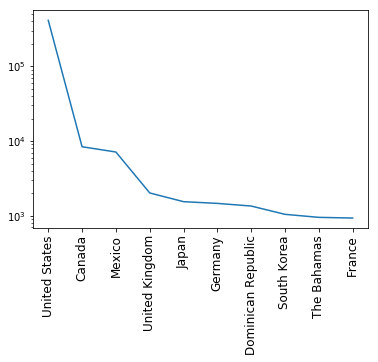

In [27]:
#plotting
end = 10
y  = result.keys().collect()[:end]
x  =range(len(y))[:end]
x_ticks_labels = result.values().collect()[:end]

import matplotlib.pyplot as plt
#%matplotlib notebook
plt.clf()
plt.plot(y)
plt.xticks(x,x_ticks_labels,rotation='vertical', fontsize=12)
plt.yscale("log")
plt.rcParams["figure.figsize"] = [15,10]
plt.show()

## Joins
- Always on pair RDDs
- Happens betwen 2 pair RDDs having common key space

In [28]:
storeAddress = [("Ritual", "1026 Valencia St"), 
                ("Philz", "748 Van Ness Ave"),  
                ("Philz", "3101 24th St"), 
                ("Starbucks", "Seattle")
               ]

storeRating = [
  ("Ritual", 4.9),
  ("Philz", 4.8)
]

addressRDD= sc.parallelize(storeAddress)
ratingRDD= sc.parallelize(storeRating)
joinedRDD= addressRDD.join(ratingRDD)

joinedRDD.collect()


[('Philz', ('748 Van Ness Ave', 4.8)),
 ('Philz', ('3101 24th St', 4.8)),
 ('Ritual', ('1026 Valencia St', 4.9))]

In [29]:
leftJoinRDD= addressRDD.leftOuterJoin(ratingRDD)
leftJoinRDD.collect()

[('Philz', ('748 Van Ness Ave', 4.8)),
 ('Philz', ('3101 24th St', 4.8)),
 ('Starbucks', ('Seattle', None)),
 ('Ritual', ('1026 Valencia St', 4.9))]

# Brodcast Variable
- What?
    - A variable stored im memory on each executor of the cluster
    - Created by the driver and sent to the excutors
- Why?
    - Typically used to make a lookup table available on every executor instead of sending it in the code or as another RDD (map-side join)

In [31]:
#implementing a join using broadcast
Employees = [(1,"sameh"), (2,"mahmoud"), (3,"zaki")]
Depts = [(1,"research"),
         (2, "sales"),
         (3, "marketing")
        ]

DeptsDict = {1:"research",
             2:"sales",
             3:"marketing"
            }

eRdd = sc.parallelize(Employees)
dRdd = sc.parallelize(Depts)

#eRdd.join(dRdd).collect()

# result = eRdd.union(dRdd).groupByKey().collect()
# for k,v in result:
#     print(k,list(v))

dvar = sc.broadcast(DeptsDict)

eRdd.map(lambda e: (e[1], dvar.value[e[0]])).collect()

#broadcastVar.value

[('sameh', 'research'), ('mahmoud', 'sales'), ('zaki', 'marketing')]

# Accumulators 
- what?
    - Opposite of a broadcasst variable
    - a mutable variable that executors can update accordingly
    - You can see the update in the Spark UI.
- why?
    -Gather stats while doing another operation

In [32]:
evenAcc = sc.accumulator(0)
oddAcc = sc.accumulator(0)
def hassanein(x):
    if x % 2 == 0:
        evenAcc.add(1)
    else:
        oddAcc.add(1)
    return x*2

result = sc.parallelize([2, 2,7, 12, 8, 90, 31, 3, 4]).map(hassanein).collect()
print(result)
(evenAcc.value, oddAcc.value)

[4, 4, 14, 24, 16, 180, 62, 6, 8]


(6, 3)

# MapPartitions/Coalesce/Repartition

In [ ]:
import time

nums = sc.parallelize(range(24),8)
see("nums.getNumPartitions()", nums.getNumPartitions())

def heavyOperation():
    ##e.g. writeToDB, http reqest,
    time.sleep(1)

def singleOp(x):
    heavyOperation()
    return x*2

def multiOp(Xs):
    heavyOperation()
    return map(lambda x: x*2, Xs)


%time y = nums.mapPartitions(multiOp).collect()
%time y = nums.mapPartitions(multiOp).collect()
%time y = nums.mapPartitions(multiOp).collect()

%time x = nums.map(singleOp).collect()
%time x = nums.map(singleOp).collect()
%time x = nums.map(singleOp).collect()


In [ ]:
#coalesce
# -- can be used only to decreases
# -- tries to avoid reshuffling
nums = nums.coalesce(4)
see("nums.getNumPartitions()", nums.getNumPartitions())

%time y = nums.mapPartitions(multiOp).collect()
%time y = nums.mapPartitions(multiOp).collect()
%time y = nums.mapPartitions(multiOp).collect()


%time x = nums.map(singleOp).collect()
%time x = nums.map(singleOp).collect()
%time x = nums.map(singleOp).collect()

In [ ]:
#repartition
# -Can increase or decrease partition
# -always reshuffles
# -Load balances partitions

nums = nums.repartition(24)
see("nums.getNumPartitions()", nums.getNumPartitions())

%time y = nums.mapPartitions(multiOp).collect()
%time y = nums.mapPartitions(multiOp).collect()
%time y = nums.mapPartitions(multiOp).collect()


%time x = nums.map(singleOp).collect()
%time x = nums.map(singleOp).collect()
%time x = nums.map(singleOp).collect()